In [36]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

# Helpers

In [37]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
def adf_test(df, response, alpha=0.05, autolag='AIC'):
    series = pd.to_numeric(df[response], errors='coerce').dropna()

    adf_stat, pval, lags, nobs, crit, _ = adfuller(series, autolag=autolag)

    is_stationary = pval < alpha

    if is_stationary:
        reason = (f'Stationary: ADF p-value={pval:.4g} < {alpha} so reject the null hyptothesis')
    else:
        reason = (f'Non-stationary: ADF p-value={pval:.4g} >= {alpha} so fail to reject the null hypothesis')

    return reason

# RNNs

In [38]:
class ElmanRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, output_dim, activation='tanh', output_activation=None, kernel_init='glorot_uniform', recurrent_init='glorot_uniform', bias_init='zeros', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.kernel_init = tf.keras.initializers.get(kernel_init)
        self.recurrent_init = tf.keras.initializers.get(recurrent_init)
        self.bias_init = tf.keras.initializers.get(bias_init)

        self.state_size = units
        self.output_size = output_dim
        self.supports_masking = True

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer=self.kernel_init, name='Wx')
        self.Wh = self.add_weight(shape=(self.units, self.units), initializer=self.recurrent_init, name='Wh')
        self.bh = self.add_weight(shape=(self.units,), initializer=self.bias_init, name='bh')

        self.Wo = self.add_weight(shape=(self.units, self.output_dim), initializer=self.kernel_init, name='Wo')
        self.bo = self.add_weight(shape=(self.output_dim,), initializer=self.bias_init, name='bo')

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_prev = states[0]

        h_t = tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + self.bh
        h_t = self.activation(h_t)

        y_t = tf.matmul(h_t, self.Wo) + self.bo

        if self.output_activation is not None:
            y_t = self.output_activation(y_t)

        return y_t, [h_t]

    def get_config(self):
        base = super().get_config()
        base.update({
            "units": self.units,
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation),
            "output_activation": tf.keras.activations.serialize(self.output_activation),
            "kernel_initializer": tf.keras.initializers.serialize(self.kernel_init),
            "recurrent_initializer": tf.keras.initializers.serialize(self.recurrent_init),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_init),
        })
        return base


def ElmanRNN(units, output_dim, return_sequences=False, **kwargs):
    cell = ElmanRNNCell(units=units, output_dim=output_dim, **kwargs)
    return tf.keras.layers.RNN(cell, return_sequences=return_sequences)


def build_elman_model(input_dim, units=64, output_dim=1, return_sequences=False, output_activation=None):
    inp = tf.keras.Input(shape=(None, input_dim))
    x = ElmanRNN(units=units, output_dim=output_dim, return_sequences=return_sequences, activation='tanh', output_activation=output_activation)(inp)
    model = tf.keras.Model(inp, x)
    return model

In [39]:
class JordanRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, output_dim, activation='tanh', output_activation=None, kernel_init='glorot_uniform', recurrent_init='glorot_uniform', bias_init='zeros', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.kernel_init = tf.keras.initializers.get(kernel_init)
        self.recurrent_init = tf.keras.initializers.get(recurrent_init)
        self.bias_init = tf.keras.initializers.get(bias_init)

        self.state_size = output_dim
        self.output_size = output_dim
        self.supports_masking = True

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer=self.kernel_init, name='Wx')
        self.Wy = self.add_weight(shape=(self.output_dim, self.units), initializer=self.recurrent_init, name='Wy')
        self.bh = self.add_weight(shape=(self.units, ), initializer=self.bias_init, name='bh')

        self.Wo = self.add_weight(shape=(self.units, self.output_dim), initializer=self.kernel_init, name='Wo')
        self.bo = self.add_weight(shape=(self.output_dim, ), initializer=self.bias_init, name='bo')

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        y_prev = states[0]

        h_t = tf.matmul(inputs, self.Wx) + tf.matmul(y_prev, self.Wy) + self.bh
        h_t = self.activation(h_t)

        y_t = tf.matmul(h_t, self.Wo) + self.bo

        if self.output_activation is not None:
            y_t = self.output_activation(y_t)
        
        return y_t, [y_t]
    
    def get_config(self):
        base = super().get_config()
        base.update({
            "units": self.units,
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation),
            "output_activation": tf.keras.activations.serialize(self.output_activation),
            "kernel_initializer": tf.keras.initializers.serialize(self.kernel_init),
            "recurrent_initializer": tf.keras.initializers.serialize(self.recurrent_init),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_init),
        })
        return base


def JordanRNN(units, output_dim, return_sequences=False, **kwargs):
    cell = JordanRNNCell(units=units, output_dim=output_dim, **kwargs)
    return tf.keras.layers.RNN(cell, return_sequences=return_sequences)


def build_jordan_model(input_dim, units=64, output_dim=1, return_sequences=False, output_activation=None):
    inp = tf.keras.Input(shape=(None, input_dim))
    x = JordanRNN(units=units, output_dim=output_dim, return_sequences=return_sequences, activation='tanh', output_activation=output_activation)(inp)
    model = tf.keras.Model(inp, x)
    return model

In [40]:
class MultiRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, output_dim, activation='tanh', output_activation=None, kernel_init='glorot_uniform', recurrent_init='glorot_uniform', bias_init='zeros', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.kernel_init = tf.keras.initializers.get(kernel_init)
        self.recurrent_init = tf.keras.initializers.get(recurrent_init)
        self.bias_init = tf.keras.initializers.get(bias_init)

        self.state_size = [units, output_dim]
        self.output_size = output_dim
        self.supports_masking = True

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer=self.kernel_init, name='Wx')
        self.Wh = self.add_weight(shape=(self.units, self.units), initializer=self.recurrent_init, name='Wh')
        self.Wy = self.add_weight(shape=(self.output_dim, self.units), initializer=self.recurrent_init, name='Wy')
        self.bh = self.add_weight(shape=(self.units, ), initializer=self.bias_init, name='bh')

        self.Wo = self.add_weight(shape=(self.units, self.output_dim), initializer=self.kernel_init, name='Wo')
        self.bo = self.add_weight(shape=(self.output_dim, ), initializer=self.bias_init, name='bo')

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_prev, y_prev = states

        # takes both
        h_t = tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + tf.matmul(y_prev, self.Wy) + self.bh
        h_t = self.activation(h_t)

        y_t = tf.matmul(h_t, self.Wo) + self.bo

        if self.output_activation is not None:
            y_t = self.output_activation(y_t)
        
        return y_t, [h_t, y_t]
    
    def get_config(self):
        base = super().get_config()
        base.update({
            "units": self.units,
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation),
            "output_activation": tf.keras.activations.serialize(self.output_activation),
            "kernel_initializer": tf.keras.initializers.serialize(self.kernel_init),
            "recurrent_initializer": tf.keras.initializers.serialize(self.recurrent_init),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_init),
        })
        return base

    
def MultiRNN(units, output_dim, return_sequences=False, **kwargs):
    cell = MultiRNNCell(units=units, output_dim=output_dim, **kwargs)
    return tf.keras.layers.RNN(cell, return_sequences=return_sequences)


def build_multi_model(input_dim, units=64, output_dim=1, return_sequences=False, output_activation=None):
    inp = tf.keras.Input(shape=(None, input_dim))
    x = MultiRNN(units=units, output_dim=output_dim, return_sequences=return_sequences, activation='tanh', output_activation=output_activation)(inp)
    model = tf.keras.Model(inp, x)
    return model

# Datasets

## AMD

In [41]:
df_amd = pd.read_csv('data/AMD.csv', parse_dates=['Date'], index_col='Date')
print(df_amd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10098 entries, 1980-03-17 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10098 non-null  float64
 1   High       10098 non-null  float64
 2   Low        10098 non-null  float64
 3   Close      10098 non-null  float64
 4   Adj Close  10098 non-null  float64
 5   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 552.2 KB
None


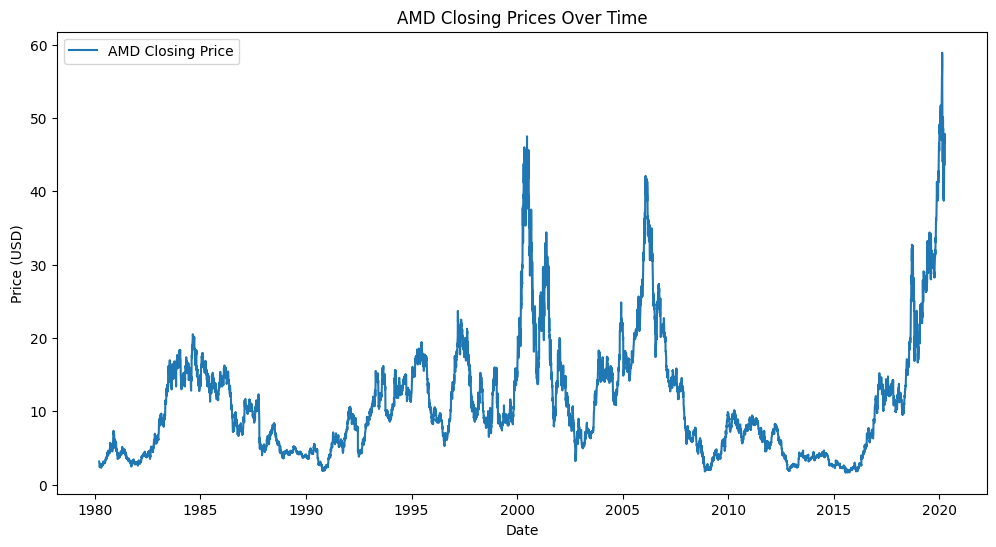

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(df_amd['Close'], label='AMD Closing Price')
plt.title('AMD Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

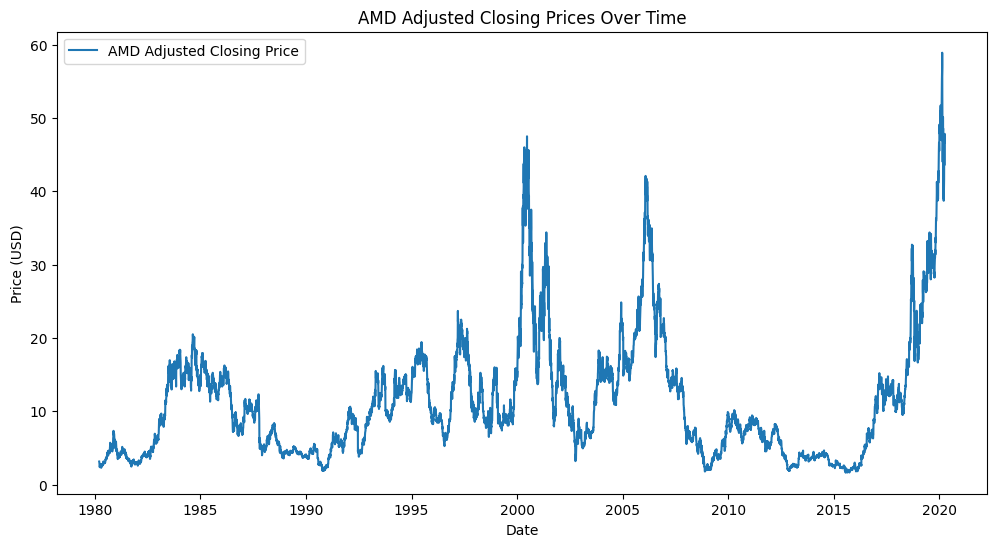

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(df_amd['Adj Close'], label='AMD Adjusted Closing Price')
plt.title('AMD Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [44]:
reason = adf_test(df_amd, 'Adj Close')
print(reason)

Non-stationary: ADF p-value=0.05468 >= 0.05 so fail to reject the null hypothesis
